# Testing

---
Stuff that i dont want to confuse in the Main

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import random
import os

import torch

In [2]:
import sys
ROOT_PATH = Path("..")  
sys.path.append(str(ROOT_PATH))
from src.dataloaders import get_dataloaders
from src.model import EfficientNetSpectrogram
import src.baseline_cnn

In [3]:
AUDIO_DIR = ROOT_PATH / "Data" / "Audio"
ANNOT_DIR = ROOT_PATH / "Data" / "Annotations"
SPECT_DIR = ROOT_PATH / "Data" / "Spectrograms"

ANNOT_FILE = ANNOT_DIR / "audio_annotations.csv"

train_df = pd.read_csv(ANNOT_DIR / "train.csv")
val_df   = pd.read_csv(ANNOT_DIR / "val.csv")
test_df  = pd.read_csv(ANNOT_DIR / "test.csv")

## Code

WestIndianManatee ---  shape: (1, 128, 111)
PantropicalSpottedDolphin ---  shape: (1, 128, 238)
KillerWhale ---  shape: (1, 128, 35)


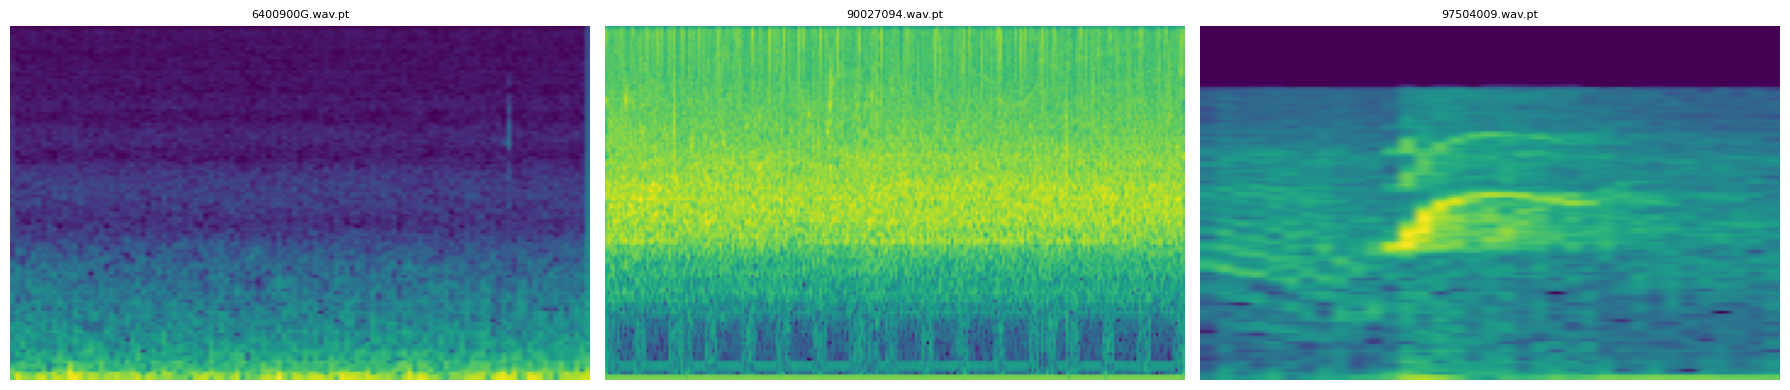

In [4]:
base_dir = ROOT_PATH / "Data" / "Spectrograms" / "train"

all_files = []
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith(".pt"):
            relative_path = os.path.join(root, f)
            all_files.append(relative_path)

if len(all_files) < 3:
    raise ValueError("Not enough .pt files found.")

# Select 3 random spectrograms
samples = random.sample(all_files, 3)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, path in zip(axes, samples):
    tensor = torch.load(path)

    species_name = os.path.basename(os.path.dirname(path))
    # Print the tensor shape and name
    print(f"{species_name} ---  shape: {tuple(tensor.shape)}")

    # Convert tensor to 2D for plotting
    if tensor.dim() == 2:
        img = tensor
    elif tensor.dim() == 3:
        # assume [C, H, W]
        img = tensor[0]  
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

    ax.imshow(img.numpy(), aspect="auto", origin="lower", cmap="viridis")
    ax.set_title(os.path.basename(path), fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

## CNN

**Dataloader**

In [5]:
SPEC_ROOT = ROOT_PATH / "Data" / "Spectrograms"

train_loader, val_loader, test_loader = get_dataloaders(
    SPEC_ROOT,
    batch_size=16
)

### Testing basic cnn

In [6]:
import torch
from src.baseline_cnn import BaselineCNN
from src.dataloaders import get_dataloaders
import src.baseline_cnn

# Ensure train_loader exists (create if not)
try:
	class_names
except NameError:
	class_names = sorted(train_df['category'].unique())

NUM_CLASSES = len(class_names)
# Get one batch
x, y = next(iter(train_loader))

print("Input batch shape:", x.shape)
print("Labels shape:", y.shape)

# CREATE MODEL WITH 44 CLASSES
baseline = BaselineCNN(input_channels=1, num_classes=NUM_CLASSES)

# Forward pass
with torch.no_grad():
    out = baseline(x)

print("Output shape:", out.shape)
print("Output:", out)

Input batch shape: torch.Size([16, 1, 128, 400])
Labels shape: torch.Size([16])
Output shape: torch.Size([16, 44])
Output: tensor([[-2.9450e-02, -3.7748e-02, -2.5181e-02, -9.7287e-02,  1.0301e-01,
         -1.9162e-02, -3.2840e-02,  4.6516e-04,  2.6719e-02, -3.7623e-02,
          1.1540e-02, -7.4523e-02,  5.5902e-02,  1.0441e-01,  7.1032e-02,
          2.4327e-02, -6.8578e-02,  8.5301e-02,  4.8852e-02,  3.8901e-02,
         -3.8685e-02,  3.2013e-02,  5.9500e-02,  8.6407e-02,  1.6413e-02,
         -1.4846e-02, -8.5924e-03,  4.7451e-03, -2.3582e-02, -2.8009e-02,
         -1.0174e-01,  5.3317e-02,  4.3458e-02,  9.1695e-03, -1.5415e-02,
         -7.7334e-02,  8.1377e-02,  4.7801e-03, -8.6781e-02, -7.9486e-02,
          6.4716e-02,  1.6850e-02, -5.8287e-02, -2.4748e-02],
        [-1.4981e-02, -1.1986e-02,  1.9107e-02, -2.8421e-02,  1.2281e-01,
         -6.2415e-02, -7.0569e-02, -1.6400e-02,  1.0799e-02, -4.9616e-02,
          6.7180e-02, -7.9120e-02,  2.2563e-02,  1.0143e-01,  4.5587e-02,
 

**For Human-readable probabilities:**

In [7]:
probs = torch.softmax(out, dim=1)
print(probs)

tensor([[0.0220, 0.0218, 0.0221, 0.0206, 0.0251, 0.0222, 0.0219, 0.0227, 0.0233,
         0.0218, 0.0229, 0.0210, 0.0240, 0.0252, 0.0243, 0.0232, 0.0212, 0.0247,
         0.0238, 0.0236, 0.0218, 0.0234, 0.0240, 0.0247, 0.0230, 0.0223, 0.0225,
         0.0228, 0.0221, 0.0220, 0.0205, 0.0239, 0.0237, 0.0229, 0.0223, 0.0210,
         0.0246, 0.0228, 0.0208, 0.0209, 0.0242, 0.0230, 0.0214, 0.0221],
        [0.0223, 0.0224, 0.0231, 0.0220, 0.0256, 0.0213, 0.0211, 0.0223, 0.0229,
         0.0216, 0.0242, 0.0209, 0.0232, 0.0251, 0.0237, 0.0232, 0.0214, 0.0246,
         0.0236, 0.0239, 0.0211, 0.0228, 0.0253, 0.0241, 0.0226, 0.0216, 0.0216,
         0.0225, 0.0225, 0.0222, 0.0216, 0.0238, 0.0238, 0.0229, 0.0210, 0.0204,
         0.0255, 0.0217, 0.0211, 0.0211, 0.0252, 0.0226, 0.0217, 0.0231],
        [0.0221, 0.0223, 0.0224, 0.0214, 0.0254, 0.0226, 0.0216, 0.0232, 0.0224,
         0.0219, 0.0239, 0.0211, 0.0243, 0.0246, 0.0233, 0.0229, 0.0214, 0.0250,
         0.0231, 0.0230, 0.0209, 0.0231, 0

*Note: example: [-0.1171, -0.0087]*
- *Score for class 0: -0.1171*
- *Score for class 1: -0.0087*

*The class with the higher logit is the predicted class.*
- *Here: -0.0087 > -0.1171 → predict class 1.*

*We have 16 predictions (16 x 2 matrix)*

### Testing EfficientNet CNN

In [8]:
from src.model import EfficientNetSpectrogram
from src.dataloaders import get_dataloaders  

# ensure class_names exists (derive from train_df if not)
try:
	class_names
except NameError:
	class_names = sorted(train_df['category'].unique())

NUM_CLASSES = len(class_names)

model = EfficientNetSpectrogram(num_classes=NUM_CLASSES)

x, y = next(iter(train_loader))

x, y = next(iter(train_loader))

print("Input batch shape:", x.shape)
print("Labels shape:", y.shape)

out = model(x)

print("Output shape:", out.shape)
print("Output:", out)

Input batch shape: torch.Size([16, 1, 128, 400])
Labels shape: torch.Size([16])
Output shape: torch.Size([16, 44])
Output: tensor([[ 3.3807e-01, -1.3362e-01,  8.0273e-02, -8.2932e-02, -2.5980e-02,
         -1.7060e-01, -3.1629e-03, -1.8522e-01,  1.5585e-02, -1.0429e-01,
          7.5796e-02, -2.1193e-01, -4.9656e-01, -8.7461e-02, -2.3944e-02,
         -6.0466e-02,  1.8463e-01, -2.5450e-03, -4.0890e-01, -3.8320e-02,
          1.3004e-01, -1.6067e-01,  1.2910e-01,  2.0805e-01,  2.1334e-01,
         -2.1877e-01, -2.6812e-02, -1.4216e-01, -9.2590e-02, -5.3281e-02,
         -2.7745e-02,  6.2165e-01,  7.7606e-02,  1.6352e-01,  7.1339e-02,
         -2.8818e-01, -1.7702e-01,  4.1807e-02, -3.6600e-02, -3.9969e-01,
          7.6778e-02, -3.8732e-01, -2.0247e-01, -2.0516e-01],
        [-2.1965e-01, -1.8696e-01,  2.8578e-01, -3.5678e-02, -1.2708e-01,
          1.9747e-02,  1.1916e-01, -2.4004e-01,  6.4635e-02, -3.3970e-01,
         -1.0599e-01,  1.9017e-01,  1.2601e-01,  2.9899e-02, -2.2172e-02,
 

**For Human-readable probabilities:**

In [9]:
probs = torch.softmax(out, dim=1)
print(probs)

tensor([[0.0327, 0.0204, 0.0252, 0.0214, 0.0227, 0.0196, 0.0232, 0.0194, 0.0237,
         0.0210, 0.0251, 0.0188, 0.0142, 0.0213, 0.0227, 0.0219, 0.0280, 0.0232,
         0.0155, 0.0224, 0.0265, 0.0198, 0.0265, 0.0287, 0.0288, 0.0187, 0.0227,
         0.0202, 0.0212, 0.0221, 0.0227, 0.0434, 0.0252, 0.0274, 0.0250, 0.0175,
         0.0195, 0.0243, 0.0225, 0.0156, 0.0252, 0.0158, 0.0190, 0.0190],
        [0.0189, 0.0195, 0.0313, 0.0227, 0.0207, 0.0240, 0.0265, 0.0185, 0.0251,
         0.0168, 0.0212, 0.0285, 0.0267, 0.0242, 0.0230, 0.0330, 0.0380, 0.0163,
         0.0244, 0.0212, 0.0227, 0.0285, 0.0221, 0.0194, 0.0244, 0.0170, 0.0264,
         0.0231, 0.0180, 0.0217, 0.0200, 0.0280, 0.0210, 0.0203, 0.0263, 0.0237,
         0.0165, 0.0224, 0.0185, 0.0219, 0.0201, 0.0258, 0.0168, 0.0148],
        [0.0306, 0.0284, 0.0234, 0.0209, 0.0156, 0.0198, 0.0229, 0.0230, 0.0236,
         0.0284, 0.0281, 0.0206, 0.0271, 0.0180, 0.0243, 0.0280, 0.0255, 0.0232,
         0.0212, 0.0263, 0.0199, 0.0154, 0

We can see in this case that EfficientNet propability outcomes differ more from each sample, meaning it recognises more deep patterns than our basic cnn

### Testing output shapes of both models
same output shapes: perfect

In [10]:
print("Input shape:", x.shape)

Input shape: torch.Size([16, 1, 128, 400])


In [11]:
out = model(x)
print("EfficientNet output shape:", out.shape)


EfficientNet output shape: torch.Size([16, 44])


In [12]:
out_base = baseline(x)
print("Baseline CNN output shape:", out_base.shape)

Baseline CNN output shape: torch.Size([16, 44])
